In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.4 MB/s eta 0:00:00


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


import warnings
warnings.filterwarnings('ignore')

# scikit-learn 관련
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import xgboost as xgb

from catboost import CatBoostClassifier

from pandas import Series

# 첫 시도

In [34]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-7/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-7/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/data/3-7/sample_submission.csv')

In [ ]:
# train 데이터 X, y 분리
X_train = df_train.drop(['id', 'booking_status'], axis = 1)
y_train = df_train['booking_status']

# test 데이터 id 제외
df_test = df_test.copy()
df_test_new = df_test.drop('id', axis = 1)

# 그리드서치를 하기 위한 여러 파라미터 설정
hyper_parameter = {
    'n_estimators' : [100, 200, 300],
    'max_depth' : [5, 10, 20]
}

# 그리드 서치로 최적의 파라미터 찾기
model = RandomForestClassifier(random_state = 42)
hyper_parameter_tuner = GridSearchCV(model, hyper_parameter, cv = 5)
hyper_parameter_tuner.fit(X_train, y_train)

# 최적의 파라미터
hyper_parameter_tuner.best_params_

{'max_depth': 10, 'n_estimators': 300}

In [ ]:
model = RandomForestClassifier(n_estimators = 300, max_depth = 10, criterion = 'entropy',random_state = 42)
model.fit(X_train, y_train)
predictions = model.predict_proba(df_test_new)[:,1]

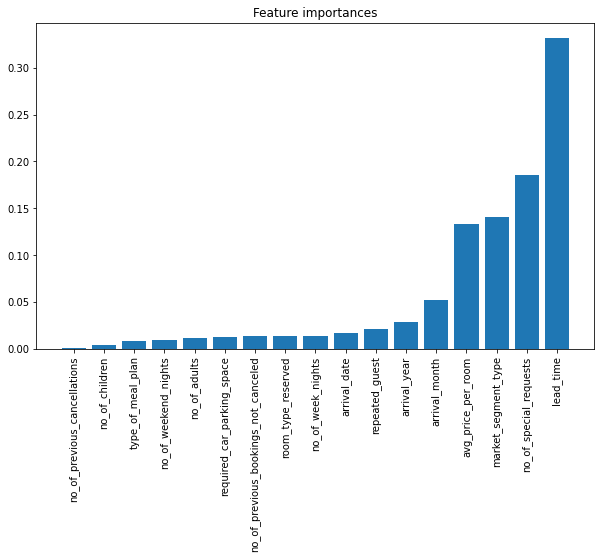

In [ ]:
# 모델링에 사용된 변수들의 중요도 시각화
importances = model.feature_importances_

indices_sorted = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X_train.columns[indices_sorted], rotation = 90)
plt.show()

In [ ]:
# train 데이터 X, y 분리
X_train = df_train.drop(['id', 'booking_status'], axis = 1)
y_train = df_train['booking_status']

# test 데이터 id 제외
df_test = df_test.copy()
df_test_new = df_test.drop('id', axis = 1)

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

model = RandomForestClassifier(n_estimators = 300, max_depth = 10, criterion = 'entropy',random_state = 42)
model.fit(X_tr, y_tr)
prediction = model.predict_proba(X_vld)[:, 1]

print('첫번째 시도 정확도 : {:.2f}%'. format(100 * roc_auc_score(y_vld, prediction)))

첫번째 시도 정확도 : 88.64%


In [ ]:
sub['booking_status'] = predictions
sub.to_csv('/content/drive/MyDrive/data/3-7/sample_submission.csv', index = False)

# 1. Dataset 확인

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-7/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-7/test.csv')

In [ ]:
df_train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


* 예측하려는 target label은 booking_status 입니다.

* 변수 설명
    * no_of_adults : 성인 수 -> 이산형
    * no_of_children : 어린이 수 -> 이산형
    * no_of_weekend_nights : 숙박 수 (주말) -> 이산형
    * no_of_week_nights : 숙박 수 (평일) -> 이산형
    * type_of_meal_plan : 식사 유형 -> 명목형
    * required_car_parking_space : 주차 공간 필요 여부(0 - 필요 없음, 1 - 필요 있음) -> 명목형
    * room_type_reserved : 예약한 객실 유형 -> 명목형
    * lead_time : 예약 날짜와 입실 날짜 차이 -> 연속형
    * arrival_year : 도착 날짜의 연도 -> 이산형
    * arrival_month : 도착 날짜의 월 -> 이산형
    * arrival_date : 도착 날짜 -> 이산형
    * market_segment_type : ? -> 명목형
    * repeated_guest : 재방문 여부(0 - 재방문 X , 1 - 재방문 O) -> 명목형
    * no_of_previous_cancellations : 전에 취소한 예약 수 -> 이산형
    * no_of_previous_bookings_not_canceled : 전에 취소하지 않은 예약 수 -> 이산형
    * avg_price_per_room : 당일 평균 가격 예약(유동적, 단위 - 유로) -> 연속형
    * no_of_special_requests : 고객이 요청한 특별 요청 수(ex - 높은 층, 객실에서 보이는 전망 등) -> 이산형
    * booking_status : 예약 취소 여부(0 - 예약 취소 x / 1 - 예약 취소 o -> 명목형

In [ ]:
df_train.shape

(42100, 19)

In [ ]:
df_test.shape

(28068, 18)

In [ ]:
df_train.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000,42100.000000
mean,21049.500000,1.920713,0.141093,0.884632,2.398005,0.239192,0.025249,0.428931,103.888029,2017.856295,7.593539,15.902945,0.728504,0.029192,0.019715,0.175772,104.566377,0.571734,0.392019
std,12153.367503,0.524950,0.450128,0.885693,1.427330,0.587674,0.156884,0.832605,81.069343,0.350795,2.829395,8.888582,0.633529,0.168347,0.325837,1.732121,37.139165,0.775041,0.488207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10524.750000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000,0.000000
50%,21049.500000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,93.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,31574.250000,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,155.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000,1.000000
max,42099.000000,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


In [ ]:
df_test.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,28068.000000,28068.000000,28068.000000,28068.00000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000,28068.000000
mean,56133.500000,1.915313,0.140872,0.88877,2.387559,0.234110,0.027006,0.430668,103.845554,2017.856705,7.583903,15.867643,0.725951,0.030711,0.024975,0.196736,104.644460,0.573643
std,8102.678014,0.526279,0.447277,0.87825,1.403213,0.581256,0.162103,0.830187,81.134833,0.350380,2.831911,8.934570,0.629044,0.172537,0.410583,1.941456,36.818948,0.769765
min,42100.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49116.750000,2.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000
50%,56133.500000,2.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,92.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,63150.250000,2.000000,0.000000,2.00000,3.000000,0.000000,0.000000,1.000000,154.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000
max,70167.000000,4.000000,9.000000,6.00000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000


* count에서 id 컬럼과 다른 숫자를 가진 컬럼이 없고 shape를 통해 나타난 행 개수와 차이가 없다.
    * null data가 없는 것 같다.

In [ ]:
df_train.isnull().sum() # null 값 수 확인

id                                      0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

## 1.1 Null data check

In [ ]:
for col in df_train.columns:
    msg = 'column : {:>40}\t Percent of NaN value : {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column :                                       id	 Percent of NaN value : 0.00%
column :                             no_of_adults	 Percent of NaN value : 0.00%
column :                           no_of_children	 Percent of NaN value : 0.00%
column :                     no_of_weekend_nights	 Percent of NaN value : 0.00%
column :                        no_of_week_nights	 Percent of NaN value : 0.00%
column :                        type_of_meal_plan	 Percent of NaN value : 0.00%
column :               required_car_parking_space	 Percent of NaN value : 0.00%
column :                       room_type_reserved	 Percent of NaN value : 0.00%
column :                                lead_time	 Percent of NaN value : 0.00%
column :                             arrival_year	 Percent of NaN value : 0.00%
column :                            arrival_month	 Percent of NaN value : 0.00%
column :                             arrival_date	 Percent of NaN value : 0.00%
column :                      market_seg

In [ ]:
for col in df_test.columns:
    msg = 'column : {:>40}\t Percent of NaN value : {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column :                                       id	 Percent of NaN value : 0.00%
column :                             no_of_adults	 Percent of NaN value : 0.00%
column :                           no_of_children	 Percent of NaN value : 0.00%
column :                     no_of_weekend_nights	 Percent of NaN value : 0.00%
column :                        no_of_week_nights	 Percent of NaN value : 0.00%
column :                        type_of_meal_plan	 Percent of NaN value : 0.00%
column :               required_car_parking_space	 Percent of NaN value : 0.00%
column :                       room_type_reserved	 Percent of NaN value : 0.00%
column :                                lead_time	 Percent of NaN value : 0.00%
column :                             arrival_year	 Percent of NaN value : 0.00%
column :                            arrival_month	 Percent of NaN value : 0.00%
column :                             arrival_date	 Percent of NaN value : 0.00%
column :                      market_seg

* train, test 모두 null data가 존재하지 않는다.

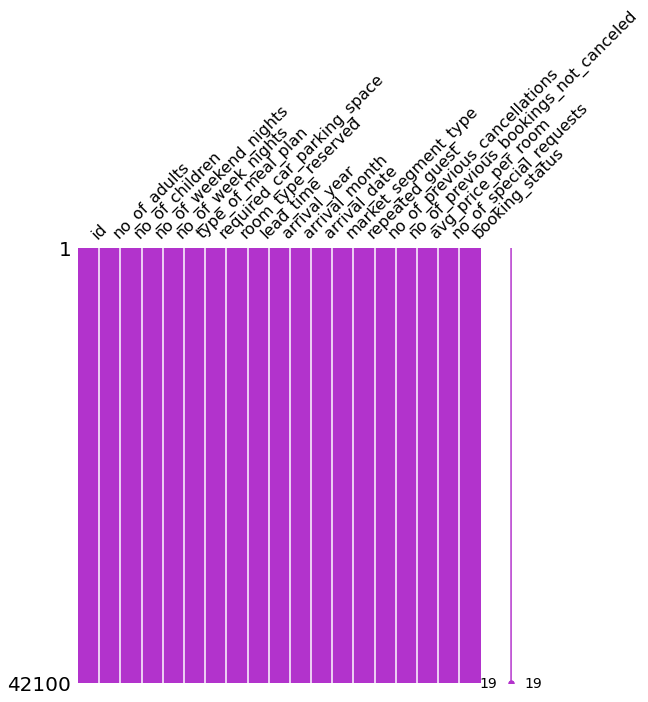

In [ ]:
msno.matrix(df = df_train.iloc[:, :], figsize = (8, 8), color = (0.7, 0.2, 0.8))

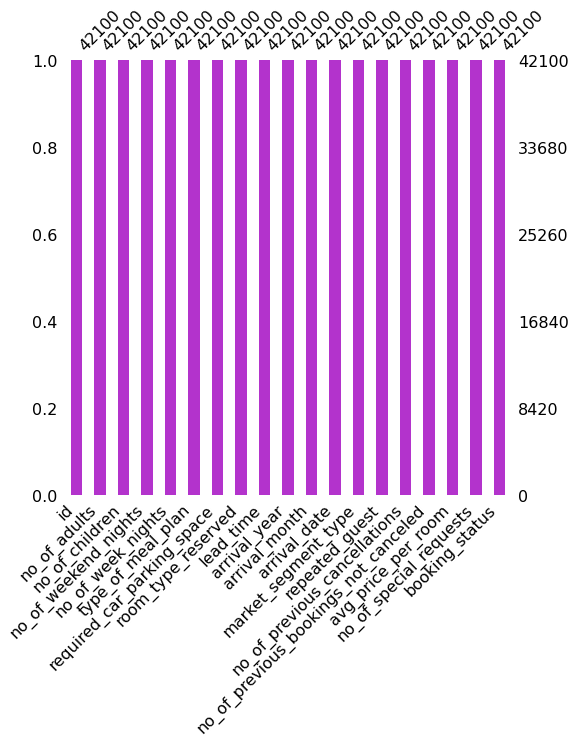

In [ ]:
msno.bar(df = df_train.iloc[:, :], figsize = (8, 8), color = (0.7, 0.2, 0.8))

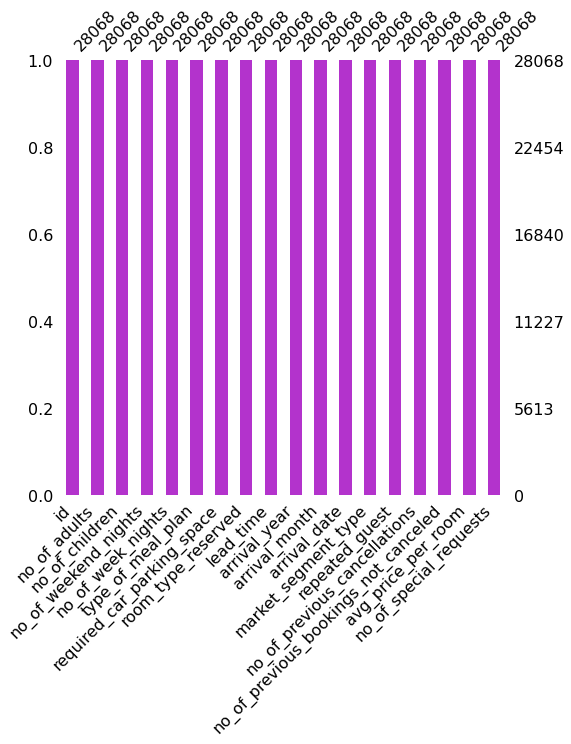

In [ ]:
msno.bar(df = df_test.iloc[:, :], figsize = (8, 8), color = (0.7, 0.2, 0.8))

## 1.2 Target label 확인

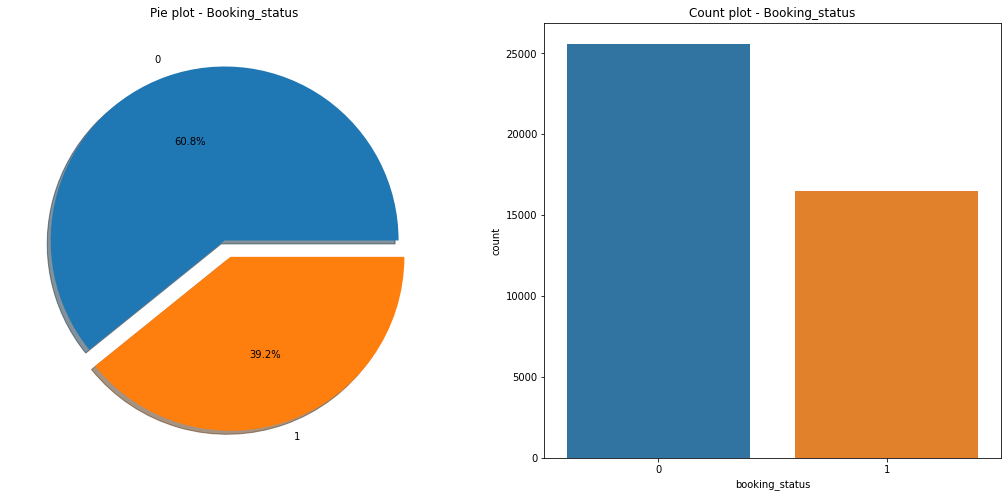

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (18, 8))

df_train['booking_status'].value_counts().plot.pie(explode = [0, 0.1], autopct = '%1.1f%%', ax = ax[0], shadow = True)
ax[0].set_title('Pie plot - Booking_status')
ax[0].set_ylabel('')

sns.countplot(data = df_train, x = 'booking_status', ax = ax[1])
ax[1].set_title('Count plot - Booking_status')

plt.show()

* 예약을 취소하지 않은 사람이 더 많다.
* train 데이터셋에서 42100명 중 16504명(39.2%) 정도가 예약을 취소했습니다.
* target label의 분포가 제법 균일하다.

# 2. Exploratory data analysis

In [ ]:
def groupping(col, target):
    return df_train[[col, target]].groupby([col], as_index=True).agg(['count', 'sum', 'mean'])

def cross(col,target):
    return pd.crosstab(df_train[col], df_train[target], margins = True).style.background_gradient(cmap = 'winter_r')

def visualization(col, target):
    f, ax = plt.subplots(3, 1, figsize = (12,15))

    sns.countplot(data = df_train, x = col, ax = ax[0])
    ax[0].set_title('No. Of {}'.format(col), y = 1.02)

    sns.countplot(data = df_train, x = col, hue = target, ax = ax[1])
    ax[1].set_title('Canceled countplot depending on {}'.format(col), y = 1.02)
    
    df_train[[col, target]].groupby([col], as_index = True).mean().sort_values(by= target, ascending=False).plot.bar(ax = ax[2])
    ax[2].set_title('Canceled rate depending on {}'.format(col), y = 1.02)

    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    plt.show()


## 2.1 no_of_adults & no_of_children 

### no_of_adults

In [ ]:
df_train[['no_of_adults', 'booking_status']].groupby(['no_of_adults'], as_index=True).count()

,booking_status
no_of_adults,
0,167
1,7089
2,30771
3,4061
4,12


In [ ]:
# booking_status가 1인 개수
df_train[['no_of_adults', 'booking_status']].groupby(['no_of_adults'], as_index=True).sum()

,booking_status
no_of_adults,
0,60
1,2000
2,12778
3,1660
4,6


In [ ]:
pd.crosstab(df_train['no_of_adults'], df_train['booking_status'], margins = True).style.background_gradient(cmap = 'winter_r')

booking_status,0,1,All
no_of_adults,,,
0,107,60,167
1,5089,2000,7089
2,17993,12778,30771
3,2401,1660,4061
4,6,6,12
All,25596,16504,42100


### no_of_children

In [ ]:
df_train[['no_of_children', 'booking_status']].groupby(['no_of_children'], as_index=True).count()

,booking_status
no_of_children,
0,37786
1,2729
2,1561
3,17
4,5
9,2


In [ ]:
# booking_status가 1인 개수
df_train[['no_of_children', 'booking_status']].groupby(['no_of_children'], as_index=True).sum()

,booking_status
no_of_children,
0,14796
1,1054
2,649
3,4
4,1
9,0


In [ ]:
pd.crosstab(df_train['no_of_children'], df_train['booking_status'], margins = True).style.background_gradient(cmap = 'winter_r')

booking_status,0,1,All
no_of_children,,,
0,22990,14796,37786
1,1675,1054,2729
2,912,649,1561
3,13,4,17
4,4,1,5
9,2,0,2
All,25596,16504,42100


### 시각화

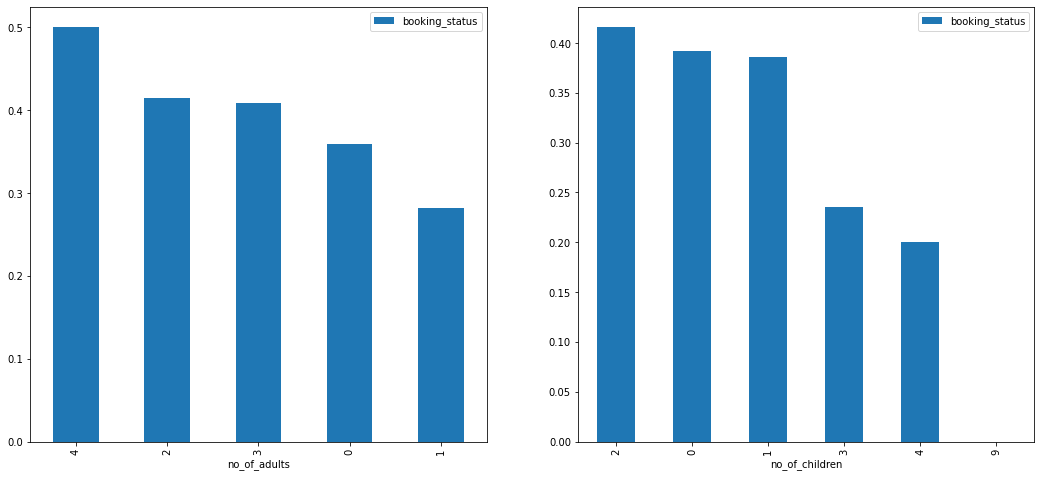

In [ ]:
# groupby 후 mean을 하면 각 어른 수, 어린이 수 별 예약 취소율을 얻을 수 있다.
f, ax = plt.subplots(1, 2, figsize = (18, 8))

# no_of_adults
df_train[['no_of_adults', 'booking_status']].groupby(['no_of_adults'], as_index = True).mean().sort_values(by = 'booking_status', ascending=False).plot.bar(ax = ax[0])

# no_of_children
df_train[['no_of_children', 'booking_status']].groupby(['no_of_children'], as_index = True).mean().sort_values(by = 'booking_status', ascending=False).plot.bar(ax = ax[1])

* 어른 수가 많은 경우가 예약 취소 확률이 높은 것을 확인할 수 있습니다.
    * 4(50%) > 2(42%) > 3(41%) > 0(36%) > 1(28%)
* 어린이 수가 적은 경우가 예약 취소 확률이 높은 것을 확인할 수 있습니다.
    * 2(42%) > 0(39.2%) > 1(38.6%) > 3(24%) > 4(20%) > 9(0%)

### Familysize 변수 생성

* no_of_adults와 no_of_children을 합하면 family가 될 것 같다.

In [ ]:
df_train['familysize'] = df_train['no_of_adults'] + df_train['no_of_children'] + 1
df_test['familysize'] = df_test['no_of_adults'] + df_test['no_of_children'] + 1

In [ ]:
print("Maximum size of Family: ", df_train['familysize'].max())
print("Minimum size of Family: ", df_train['familysize'].min())

Maximum size of Family:  12
Minimum size of Family:  1


* 미국에서는 18세를 기준으로 성인과 미성년자를 구분 짓고 있다.
* 0인 경우가 있는 것으로 보아 예약자는 포함이 안되있는 것 같다.
    * familysize에 1을 더해주어야 할 것 같다.

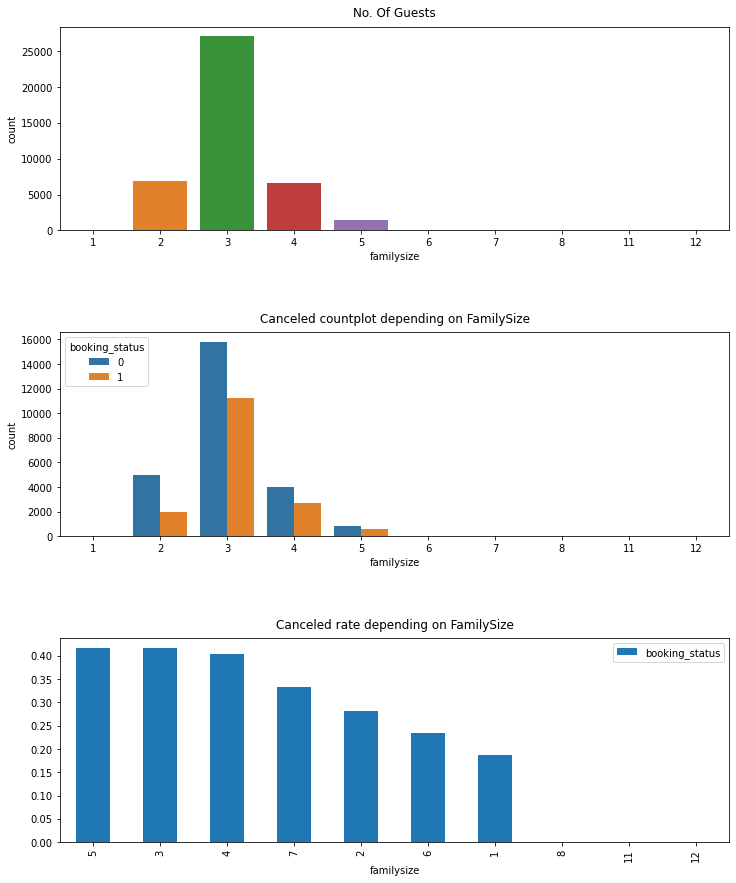

In [ ]:
f, ax = plt.subplots(3, 1, figsize = (12,15))

sns.countplot(data = df_train, x = 'familysize', ax = ax[0])
ax[0].set_title('No. Of Guests', y = 1.02)

sns.countplot(data = df_train, x = 'familysize', hue = 'booking_status', ax = ax[1])
ax[1].set_title('Canceled countplot depending on FamilySize', y = 1.02)

df_train[['familysize', 'booking_status']].groupby(['familysize'], as_index = True).mean().sort_values(by='booking_status', ascending=False).plot.bar(ax = ax[2])
ax[2].set_title('Canceled rate depending on FamilySize', y = 1.02)

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.show()

* 가족크기가 1~12까지 있고 대부분 3명이고 그 이후로는 2,4,5명이다.
* 5명인 경우가 가장 취소 확률이 높다. 
* 3~5명인 경우가 대체로 예약 취소를 하고 그 이상이거 이하인 경우는 취소확률이 낮아진다. 

## 2.2 no_of_weekend_nights & no_of_week_nights

### no_of_weekend_nights

In [ ]:
df_train[['no_of_weekend_nights', 'booking_status']].groupby(['no_of_weekend_nights'], as_index=True).count()

,booking_status
no_of_weekend_nights,
0,18137
1,11389
2,12143
3,239
4,128
5,46
6,17
7,1


In [ ]:
# booking_status가 1인 개수
df_train[['no_of_weekend_nights', 'booking_status']].groupby(['no_of_weekend_nights'], as_index=True).sum()

,booking_status
no_of_weekend_nights,
0,6655
1,4637
2,5000
3,113
4,73
5,18
6,8
7,0


In [ ]:
pd.crosstab(df_train['no_of_weekend_nights'], df_train['booking_status'], margins = True).style.background_gradient(cmap = 'winter_r')

booking_status,0,1,All
no_of_weekend_nights,,,
0,11482,6655,18137
1,6752,4637,11389
2,7143,5000,12143
3,126,113,239
4,55,73,128
5,28,18,46
6,9,8,17
7,1,0,1
All,25596,16504,42100


### no_of_week_nights

In [ ]:
df_train[['no_of_week_nights', 'booking_status']].groupby(['no_of_week_nights'], as_index=True).count()

,booking_status
no_of_week_nights,
0,1937
1,9558
2,12905
3,10286
4,4175
5,2573
6,237
7,160
8,84


In [ ]:
# booking_status가 1인 개수
df_train[['no_of_week_nights', 'booking_status']].groupby(['no_of_week_nights'], as_index=True).sum()

,booking_status
no_of_week_nights,
0,776
1,3465
2,4884
3,3954
4,1826
5,1249
6,132
7,84
8,51


In [ ]:
pd.crosstab(df_train['no_of_week_nights'], df_train['booking_status'], margins = True).style.background_gradient(cmap = 'winter_r')

booking_status,0,1,All
no_of_week_nights,,,
0,1161,776,1937
1,6093,3465,9558
2,8021,4884,12905
3,6332,3954,10286
4,2349,1826,4175
5,1324,1249,2573
6,105,132,237
7,76,84,160
8,33,51,84


### 시각화

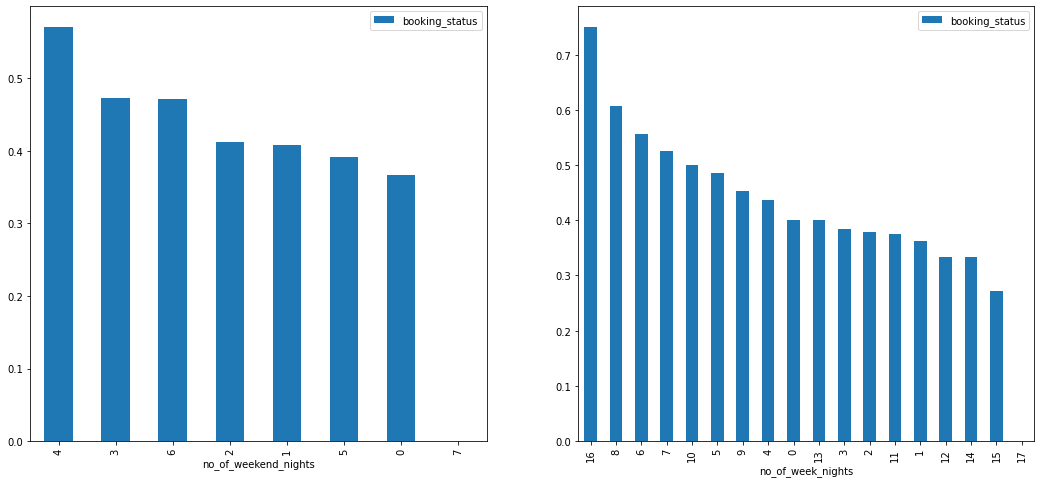

In [ ]:
# groupby 후 mean을 하면 각 주말 숙박 수, 평일 숙박 수 별 예약 취소율을 얻을 수 있다.
f, ax = plt.subplots(1, 2, figsize = (18, 8))

# no_of_weekend_nights
df_train[['no_of_weekend_nights', 'booking_status']].groupby(['no_of_weekend_nights'], as_index = True).mean().sort_values(by = 'booking_status', ascending=False).plot.bar(ax = ax[0])

# no_of_week_nights
df_train[['no_of_week_nights', 'booking_status']].groupby(['no_of_week_nights'], as_index = True).mean().sort_values(by = 'booking_status', ascending=False).plot.bar(ax = ax[1])

* 주말 숙박을 4일 한 경우가 예약 취소 확률이 가장 높았다.
    * 총 숙박을 9일 ~ 19일 사이가 예약 취소 확률이 높았다고 할 수 있다. 
* 평일 숙박을 16일 한 경우가 예약 취소 확률이 가장 높았다.
    * 총 숙박을 16일 ~ 24일  사이가 예약 취소 확률이 높았다고 할 수 있다.

In [ ]:
# 주말 숙박이 4일인 경우
df_train[df_train['no_of_weekend_nights'] == 4]

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,familysize
934,934,2,0,4,6,1,0,0,12,2018,2,20,1,0,0,0,79.00,1,0,3
1004,1004,2,0,4,6,0,0,0,95,2018,4,17,1,0,0,0,72.80,0,0,3
1456,1456,1,0,4,5,2,0,0,7,2018,9,21,0,0,0,0,296.00,0,0,2
1663,1663,2,0,4,6,1,0,0,240,2018,12,31,1,0,0,0,70.55,0,1,3
1788,1788,1,0,4,6,0,0,0,8,2017,9,3,1,0,0,0,98.50,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39470,39470,2,0,4,5,0,0,1,207,2018,8,24,1,0,0,0,123.25,1,1,3
39535,39535,2,0,4,11,1,0,0,11,2018,11,14,1,0,0,0,75.86,0,1,3
41118,41118,2,0,4,8,0,0,1,36,2018,3,1,1,0,0,0,131.40,0,1,3
41631,41631,2,0,4,10,0,0,0,19,2017,11,2,1,0,0,0,90.95,2,0,3


In [ ]:
# 평일 숙박이 16일인 경우
df_train[df_train['no_of_week_nights'] == 16]

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,familysize
13392,13392,2,0,6,16,0,0,1,10,2018,4,16,1,0,0,0,128.86,0,1,3
20841,20841,1,0,6,16,0,0,0,109,2018,5,4,1,0,0,0,89.25,0,1,2
31520,31520,3,0,5,16,0,0,0,87,2017,7,16,1,0,0,0,14.25,2,0,4
31522,31522,3,0,5,16,0,0,1,165,2018,7,18,1,0,0,0,130.05,2,1,4


In [ ]:
# 주말 숙박이 7일인 경우
df_train[df_train['no_of_weekend_nights'] == 7]

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,familysize
37033,37033,1,0,7,1,0,0,0,111,2018,6,3,0,0,0,0,96.67,1,0,2


* 주말 숙박이 7일인데 평일 숙박이 1일일 수 있을까??

In [ ]:
# 평일 숙박이 17일인 경우
df_train[df_train['no_of_week_nights'] == 17]

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,familysize
11529,11529,2,0,6,17,1,0,0,18,2018,11,14,1,0,0,0,75.82,0,0,3
12831,12831,1,0,6,17,0,0,0,9,2018,1,28,1,0,0,0,68.23,0,0,2


### total_nights 변수 생성

* no_of_weekend_nights와 no_of_week_nights을 합하면 total_nights가 될 것 같다.
* total_nights가 16 ~ 19 사이일 때 취소확률이 높게 나타날 것 같다.

In [ ]:
df_train['total_nights'] = df_train['no_of_weekend_nights'] + df_train['no_of_week_nights']
df_test['total_nights'] = df_test['no_of_weekend_nights'] + df_test['no_of_week_nights']

In [ ]:
print("Maximum nights: ", df_train['total_nights'].max())
print("Minimum nights: ", df_train['total_nights'].min())

Maximum nights:  23
Minimum nights:  0


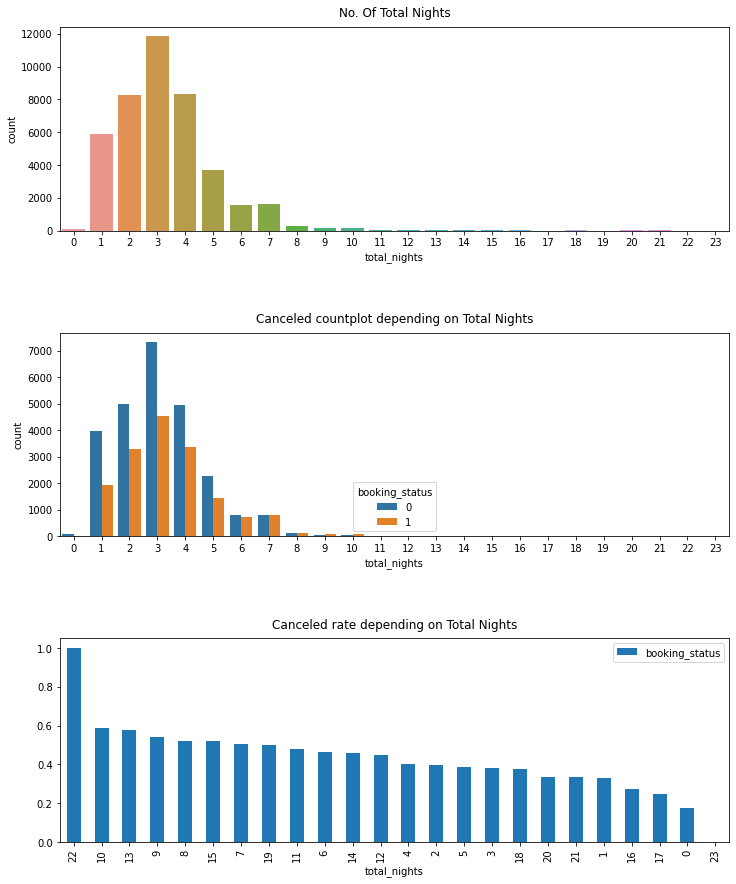

In [ ]:
f, ax = plt.subplots(3, 1, figsize = (12,15))

sns.countplot(data = df_train, x = 'total_nights', ax = ax[0])
ax[0].set_title('No. Of Total Nights', y = 1.02)

sns.countplot(data = df_train, x = 'total_nights', hue = 'booking_status', ax = ax[1])
ax[1].set_title('Canceled countplot depending on Total Nights', y = 1.02)

df_train[['total_nights', 'booking_status']].groupby(['total_nights'], as_index = True).mean().sort_values(by='booking_status', ascending=False).plot.bar(ax = ax[2])
ax[2].set_title('Canceled rate depending on Total Nights', y = 1.02)

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.show()

* 총 숙박일 수가 0일~23일까지 있고 대부분 3일이고 그 이후로는 2,4,1일이다.
* 22일인 경우가 가장 취소 확률이 높다.
    * 22일인 경우가 적기 때문일수 있다.
* 예상했던 16 ~ 19일 사이의 취소확률은 그리 높지 않다. 

## 2.3 type_of_meal_plan

In [ ]:
groupping('type_of_meal_plan','booking_status')

booking_status                 
                           count    sum      mean
type_of_meal_plan                                
0                          35463  13361  0.376759
1                           3210   1784  0.555763
2                           3421   1358  0.396960
3                              6      1  0.166667

In [ ]:
cross('type_of_meal_plan', 'booking_status')

booking_status,0,1,All
type_of_meal_plan,,,
0,22102,13361,35463
1,1426,1784,3210
2,2063,1358,3421
3,5,1,6
All,25596,16504,42100


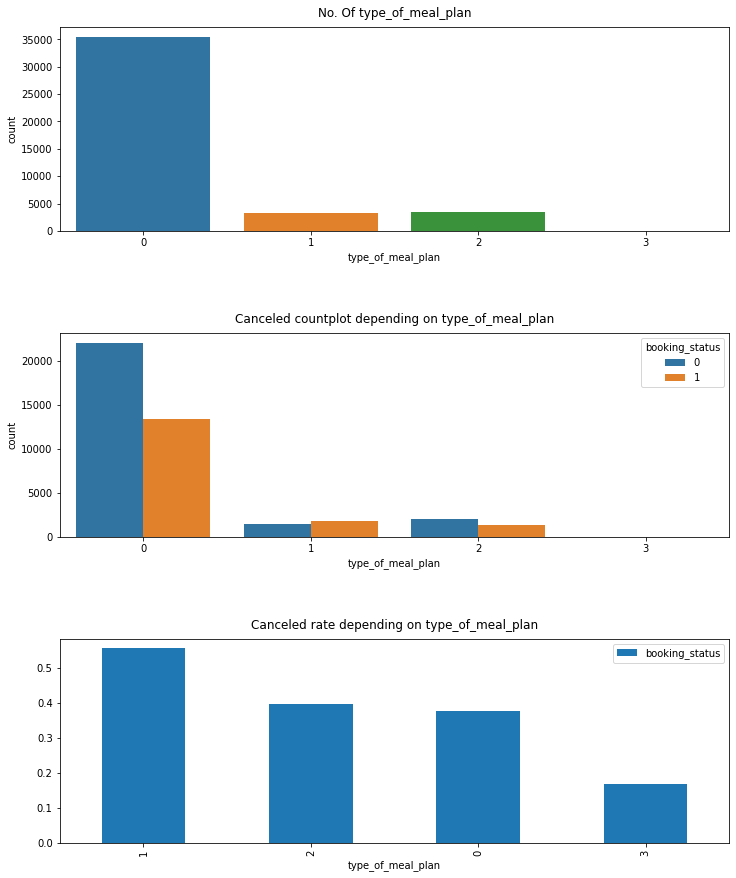

In [ ]:
visualization('type_of_meal_plan', 'booking_status')

* 식사 유형은 총 4가지가 있고 대부분 0 유형을 많이 먹는다.
* 식사 유형이 1인 경우가 가장 취소 확률이 높다.
    * 유일하게 1인 경우가 취소확률이 취소 안한 확률 보다 높다.

## 2.4 required_car_parking_space

In [ ]:
groupping('required_car_parking_space','booking_status')

booking_status                 
                                    count    sum      mean
required_car_parking_space                                
0                                   41037  16388  0.399347
1                                    1063    116  0.109125

In [ ]:
df_train.groupby(['required_car_parking_space', 'booking_status'])['booking_status'].count()

required_car_parking_space  booking_status
0                           0                 24649
                            1                 16388
1                           0                   947
                            1                   116
Name: booking_status, dtype: int64

In [ ]:
cross('required_car_parking_space', 'booking_status')

booking_status,0,1,All
required_car_parking_space,,,
0,24649,16388,41037
1,947,116,1063
All,25596,16504,42100


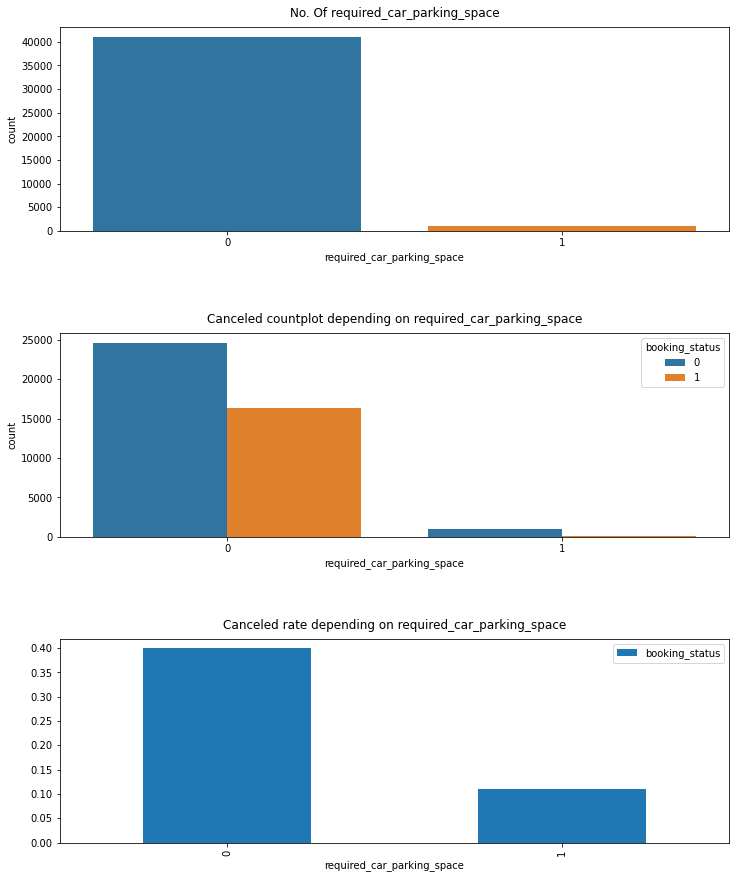

In [ ]:
visualization('required_car_parking_space', 'booking_status')

* 대부분의 사람들은 주차 공간을 요구하지 않는다.
* 주차 공간을 요구하지 않지만 예약을 취소한 사람은 주차 공간을 요구하지만 예약을 취소한 사람보다 150배 많습니다.
* 주차 공간을 요구하지 않는 사람들이 취소확률이 더 높다.
    * 주차 공간을 요구하지 않는 사람의 취소확률은 약40%이고 주차 공간을 요구한 사람의 취소확률은 15%도 되지 않았다. 
* 이번 변수의 분포가 균일하지 않기 때문에 유의미한 결과를 줄 수 있지는 않을 것 같다.
* special request에 영향을 줄까?
    * 주차 공간을 필요료 하는 사람들은 모두 특별 요청 사항이 1개 이상일지...

## 2.5 room_type_reserved

In [ ]:
groupping('room_type_reserved', 'booking_status')

booking_status                 
                            count    sum      mean
room_type_reserved                                
0                           29853  11743  0.393361
1                            9135   3690  0.403941
2                            1131    357  0.315650
3                            1465    604  0.412287
4                             320     83  0.259375
5                             190     26  0.136842
6                               6      1  0.166667

In [ ]:
cross('room_type_reserved', 'booking_status')

booking_status,0,1,All
room_type_reserved,,,
0,18110,11743,29853
1,5445,3690,9135
2,774,357,1131
3,861,604,1465
4,237,83,320
5,164,26,190
6,5,1,6
All,25596,16504,42100


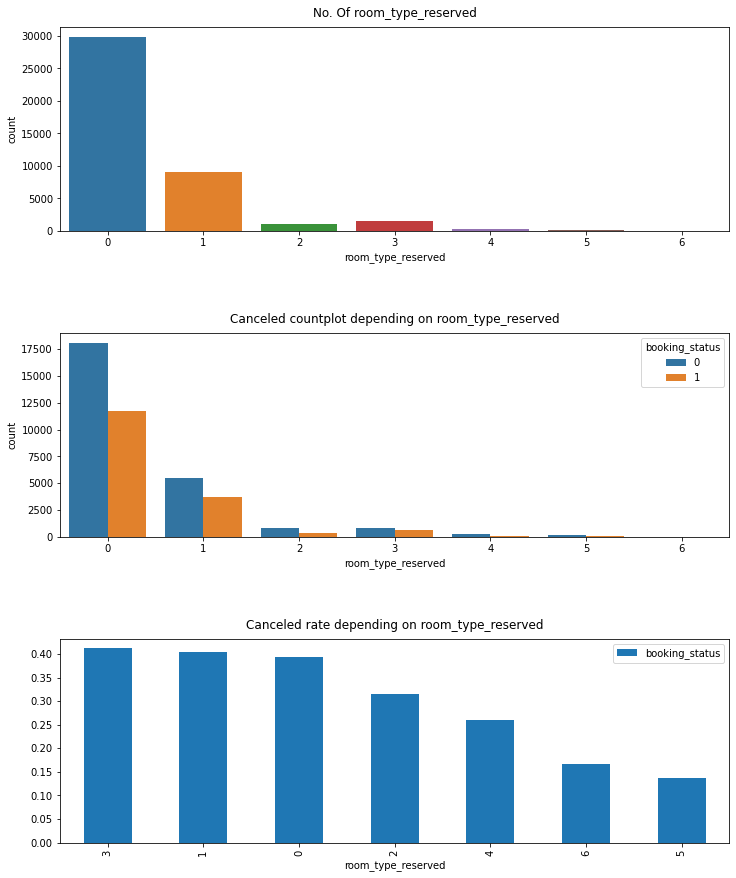

In [ ]:
visualization('room_type_reserved', 'booking_status')

* 대체로 방의 유형은 0이 많다. 그 이후로는 1, 3, 2 순으로 많다.
* 방 유형 개수가 많은 0,1,3이 취소확률이 비슷하게 높다.

## 2.6 lead_time

In [ ]:
print('제일 차이 많이 나는 일 수: {:.1f} Days'.format(df_train['lead_time'].max()))
print('제일 차이 적게 나는 일 수 : {:.1f} Days'.format(df_train['lead_time'].min()))
print('평균 차이 일 수: {:.1f} Days'.format(df_train['lead_time'].mean()))

제일 차이 많이 나는 일 수: 443.0 Days
제일 차이 적게 나는 일 수 : 0.0 Days
평균 차이 일 수: 103.9 Days


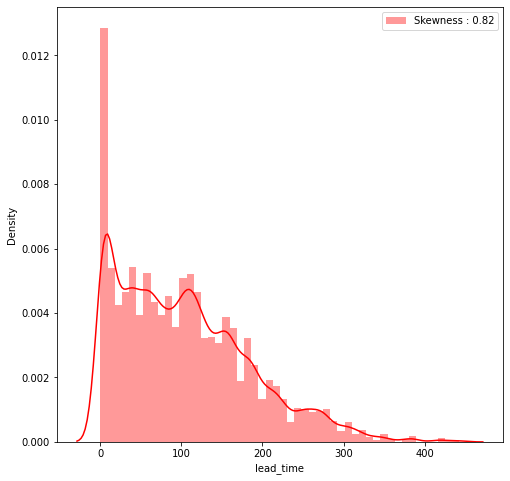

In [ ]:
# lead time histogram
fig, ax = plt.subplots(1, 1, figsize = (8,8))

g = sns.distplot(df_train['lead_time'], color = 'r', label = 'Skewness : {:.2f}'.format(df_train['lead_time'].skew()), ax = ax)
g = g.legend(loc='best')

* lead time의 왜도가 과도하게 크지 않으므로 log를 취할 필요가 없다.

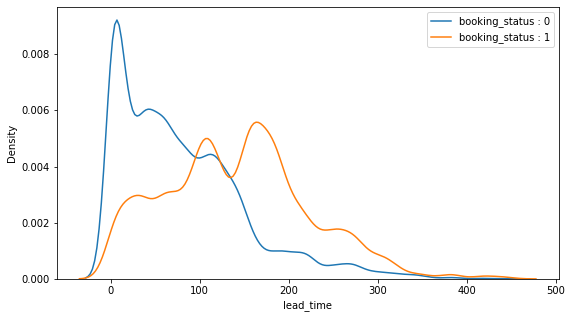

In [ ]:
# 예약 취소에 따른 lead time histogram
fig, ax = plt.subplots(1, 1, figsize = (9, 5))

sns.kdeplot(df_train[df_train['booking_status'] == 0]['lead_time'], ax = ax)

sns.kdeplot(df_train[df_train['booking_status'] == 1]['lead_time'], ax = ax)

plt.legend(['booking_status : 0', 'booking_status : 1'])
plt.show()

* 대체로 예약을 100일 이상 전에 한 경우가 예약 취소를 많이 했다.

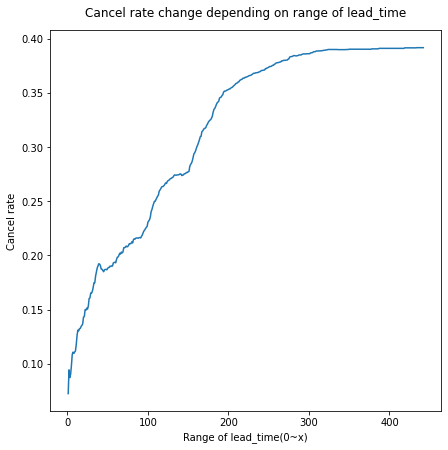

In [ ]:
cummulate_cancel_ratio = []
for i in range(0, 443):
    cummulate_cancel_ratio.append(df_train[df_train['lead_time'] < i]['booking_status'].sum() / len(df_train[df_train['lead_time'] < i]['booking_status']))

plt.figure(figsize = (7, 7))
plt.plot(cummulate_cancel_ratio)
plt.title('Cancel rate change depending on range of lead_time', y = 1.02)
plt.ylabel('Cancel rate')
plt.xlabel('Range of lead_time(0~x)')
plt.show()

* 예약을 미리 할수록 예약 취소율이 확실히 높아지고 있다.

## 2.7 arrival_year & arrival_month & arrival_date

### arrival_year

In [ ]:
groupping('arrival_year', 'booking_status')

booking_status                 
                      count    sum      mean
arrival_year                                
2017                   6050   1086  0.179504
2018                  36050  15418  0.427684

In [ ]:
cross('arrival_year', 'booking_status')

booking_status,0,1,All
arrival_year,,,
2017,4964,1086,6050
2018,20632,15418,36050
All,25596,16504,42100


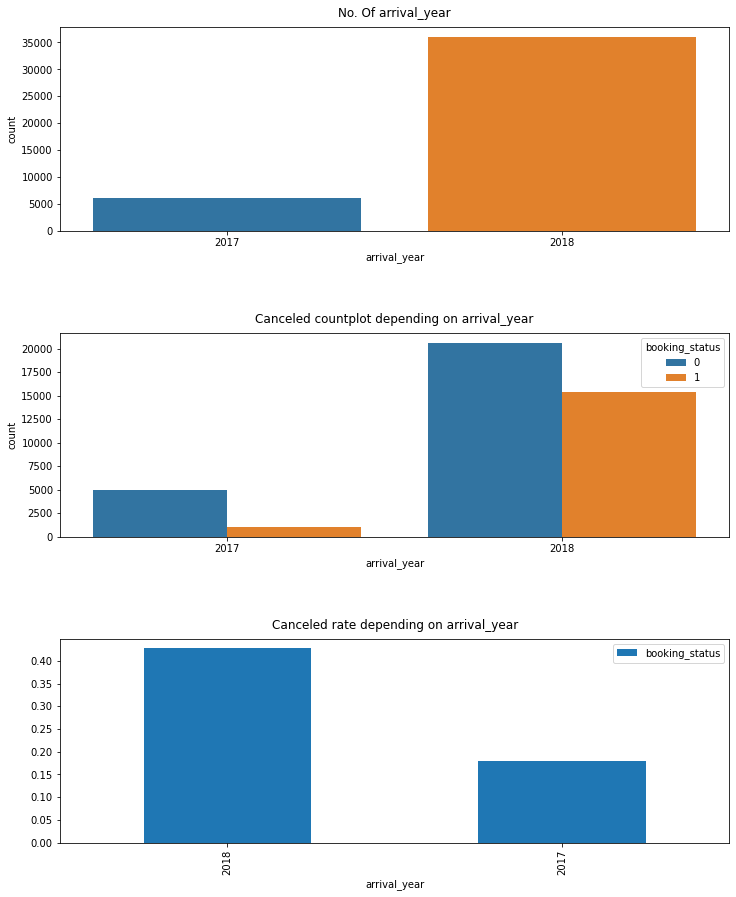

In [ ]:
visualization('arrival_year', 'booking_status')

* 2018년 데이터가 2017년 보다 훨씬 많다.
* 2018년이 취소확률이 더 높다.
    * 두 데이터의 양이 같지 않으므로 year보다는 month의 영향을 더 받을 것 같다.

### arrival_month

In [ ]:
groupping('arrival_month','booking_status')

booking_status                
                       count   sum      mean
arrival_month                               
1                        805    58  0.072050
2                       1201   317  0.263947
3                       2201   624  0.283507
4                       3006  1082  0.359947
5                       3292  1337  0.406136
6                       3356  1411  0.420441
7                       4681  2218  0.473830
8                       5763  3041  0.527677
9                       5148  2167  0.420940
10                      6453  2923  0.452968
11                      2803   774  0.276133
12                      3391   552  0.162784

In [ ]:
cross('arrival_month','booking_status')

booking_status,0,1,All
arrival_month,,,
1,747,58,805
2,884,317,1201
3,1577,624,2201
4,1924,1082,3006
5,1955,1337,3292
6,1945,1411,3356
7,2463,2218,4681
8,2722,3041,5763
9,2981,2167,5148


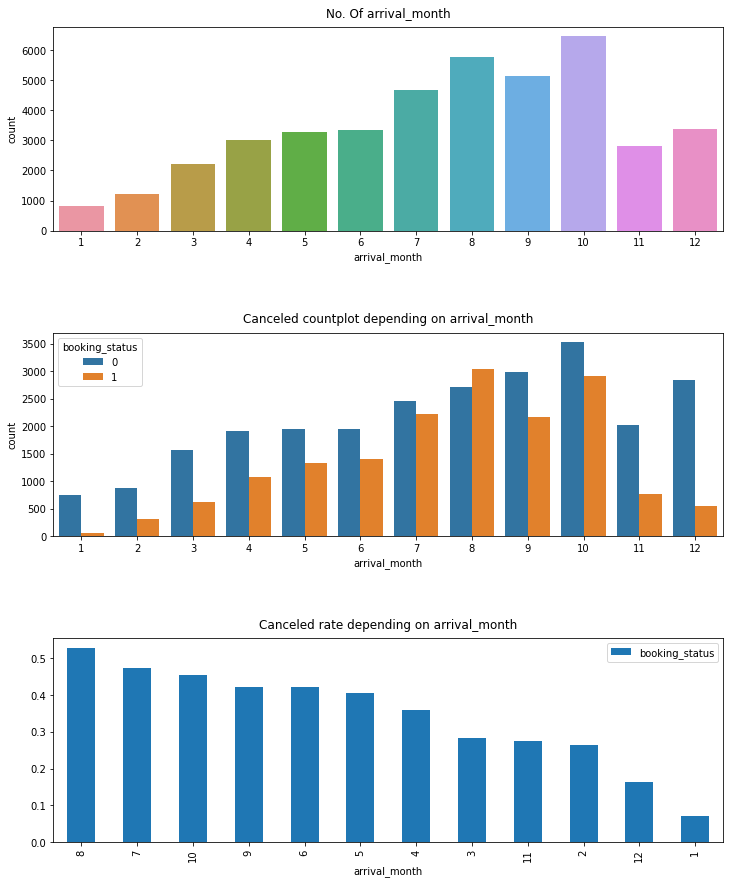

In [ ]:
visualization('arrival_month','booking_status')

* 10월 데이터가 가장 많다.
* 취소확률은 8월이 가장 높고 이후 7월, 10월, 9월 순이다.
    * 8월의 경우 취소확률이 더 높았다.
* 겨울보다는 여름에 취소확률이 높았고 봄 보다는 가을에 취소 확률이 높았다.
* 월 별 데이터 수로 보아 2017년 7월 ~ 2018년 10월 사이의 데이터인 것 같다. -> x

In [ ]:
df_train[df_train['arrival_year'] == 2017]['arrival_month'].value_counts()

10    1734
9     1310
12    1089
8      830
11     648
7      407
5        8
6        7
2        5
1        5
4        4
3        3
Name: arrival_month, dtype: int64

In [ ]:
df_train[df_train['arrival_year'] == 2018]['arrival_month'].value_counts()

8     4933
10    4719
7     4274
9     3838
6     3349
5     3284
4     3002
12    2302
3     2198
11    2155
2     1196
1      800
Name: arrival_month, dtype: int64

* 2017, 2018년 모두 1월~12월 데이터 존재
    * 단순히 2018년에 예약 건수가 더 많았다.

### arrival_date

In [ ]:
groupping('arrival_date', 'booking_status')

booking_status               
                      count  sum      mean
arrival_date                              
1                      1428  635  0.444678
2                      1408  473  0.335938
3                      1280  496  0.387500
4                      1438  579  0.402643
5                      1367  481  0.351865
6                      1426  639  0.448107
7                      1206  452  0.374793
8                      1412  511  0.361898
9                      1424  541  0.379916
10                     1253  473  0.377494
11                     1278  511  0.399844
12                     1339  572  0.427184
13                     1479  512  0.346180
14                     1164  415  0.356529
15                     1376  665  0.483285
16                     1600  709  0.443125
17                     1426  538  0.377279
18                     1291  465  0.360186
19                     1333  517  0.387847
20                     1437  499  0.347251
21                     1326  486  0.366516
22                     1274  566  0.444270
23                     1342  532  0.396423
24                     1218  472  0.387521
25                     1447  527  0.364202
26                     1460  565  0.386986
27                     1633  585  0.358236
28                     1398  650  0.464950
29                     1392  519  0.372845
30                     1538  653  0.424577
31                      707  266  0.376238

In [ ]:
cross('arrival_date', 'booking_status')

booking_status,0,1,All
arrival_date,,,
1,793,635,1428
2,935,473,1408
3,784,496,1280
4,859,579,1438
5,886,481,1367
6,787,639,1426
7,754,452,1206
8,901,511,1412
9,883,541,1424


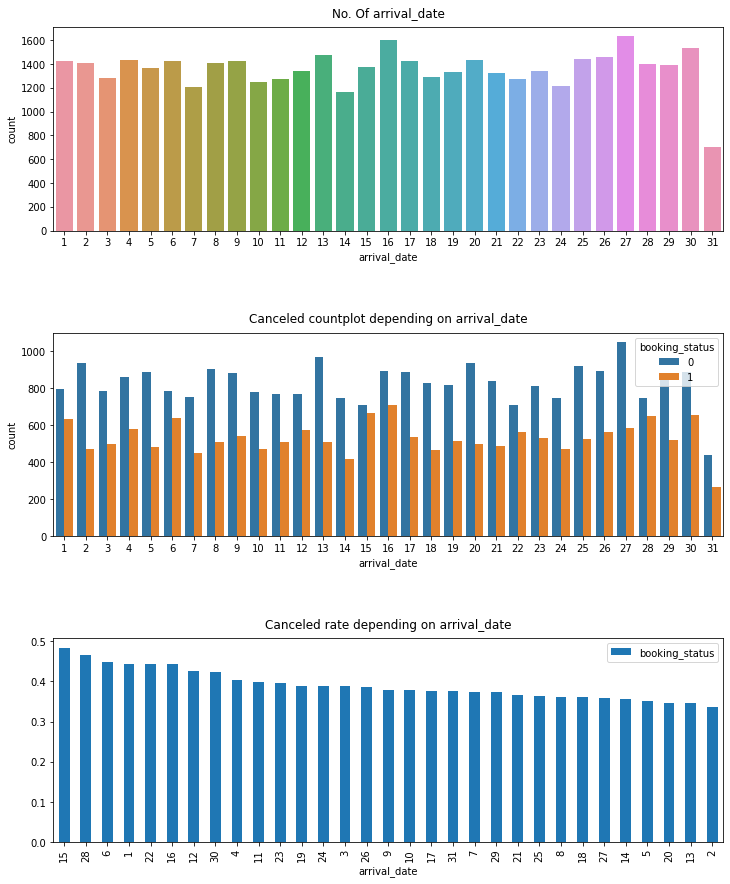

In [ ]:
visualization('arrival_date', 'booking_status')

### 연월일 합치기

In [ ]:
df_train = df_train.astype({'arrival_year' : 'str', 'arrival_month' : 'str', 'arrival_date' : 'str'})
df_train['ymd'] = df_train['arrival_year'] + '-' + df_train['arrival_month'] + '-' + df_train['arrival_date']
df_train['ymd'] = pd.to_datetime(df_train['ymd'])
df_train['ymd']

ParserError: ignored

In [ ]:
df_test = df_test.astype({'arrival_year' : 'str', 'arrival_month' : 'str', 'arrival_date' : 'str'})
df_test['ymd'] = df_test['arrival_year'] + '-' + df_test['arrival_month'] + '-' + df_test['arrival_date']
df_test['ymd'] = pd.to_datetime(df_test['ymd'])
df_test['ymd']

ParserError: ignored

* train, test 데이터 모두 2018-2-29일 데이터가 이 날은 존재하는데 존재하지 않는 날짜이다. 

## 2.8 market_segment_type

In [ ]:
groupping('market_segment_type', 'booking_status')

booking_status                 
                             count    sum      mean
market_segment_type                                
0                            14306   3233  0.225989
1                            25885  13084  0.505466
2                             1384    162  0.117052
3                               83     18  0.216867
4                              442      7  0.015837

In [ ]:
cross('market_segment_type', 'booking_status')

booking_status,0,1,All
market_segment_type,,,
0,11073,3233,14306
1,12801,13084,25885
2,1222,162,1384
3,65,18,83
4,435,7,442
All,25596,16504,42100


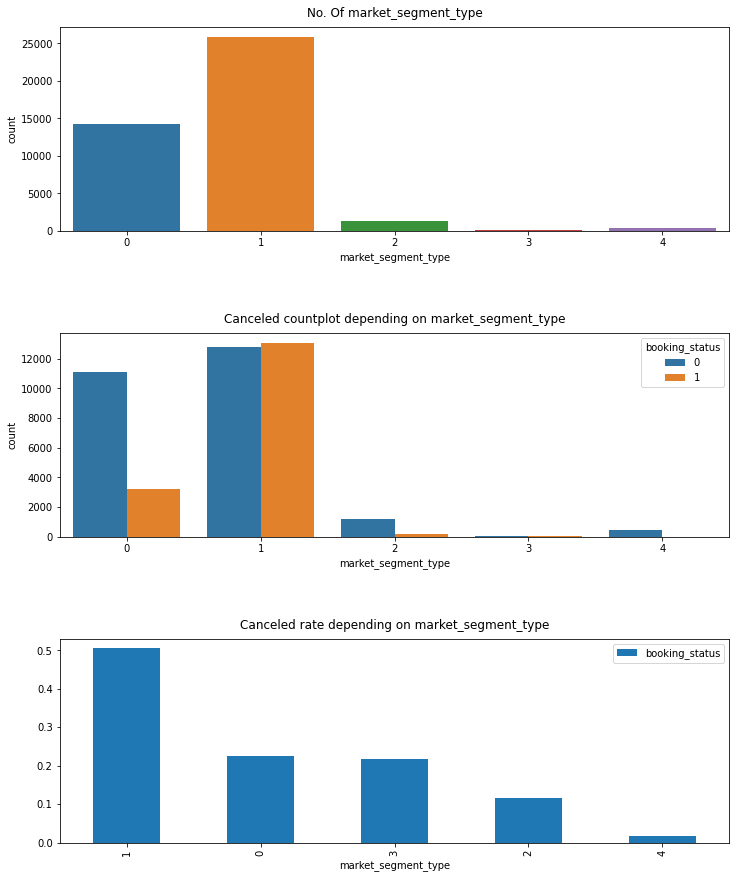

In [ ]:
visualization('market_segment_type', 'booking_status')

* 대체로 0,1유형이 많았다.
* 유형1의 경우 취소확률이 더 높았다.

## 2.9 repeated_guest

In [ ]:
groupping('repeated_guest', 'booking_status')

booking_status                 
                        count    sum      mean
repeated_guest                                
0                       40871  16493  0.403538
1                        1229     11  0.008950

In [ ]:
df_train.groupby(['repeated_guest', 'booking_status'])['booking_status'].count()

repeated_guest  booking_status
0               0                 24378
                1                 16493
1               0                  1218
                1                    11
Name: booking_status, dtype: int64

In [ ]:
cross('repeated_guest', 'booking_status')

booking_status,0,1,All
repeated_guest,,,
0,24378,16493,40871
1,1218,11,1229
All,25596,16504,42100


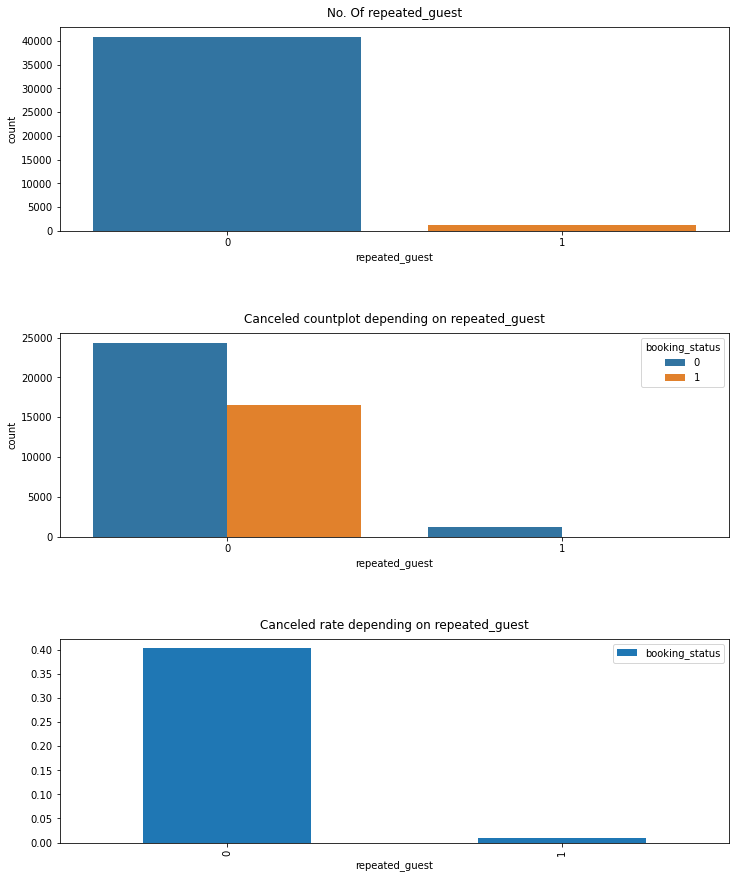

In [ ]:
visualization('repeated_guest', 'booking_status')

* 재방문한 사람은 1229명 정도이다.
* 재방문한 사람은 거의 예약을 취소하지 않는다.

## 2.10 no_of_previous_cancellations & no_of_previous_bookings_not_canceled

### no_of_previous_cancellations

In [ ]:
groupping('no_of_previous_cancellations', 'booking_status')

booking_status                 
                                      count    sum      mean
no_of_previous_cancellations                                
0                                     41755  16498  0.395114
1                                       195      4  0.020513
2                                        53      0  0.000000
3                                        51      1  0.019608
4                                        15      0  0.000000
5                                         3      0  0.000000
6                                         2      0  0.000000
8                                         1      0  0.000000
11                                       22      0  0.000000
13                                        3      1  0.333333

In [ ]:
cross('no_of_previous_cancellations', 'booking_status')

booking_status,0,1,All
no_of_previous_cancellations,,,
0,25257,16498,41755
1,191,4,195
2,53,0,53
3,50,1,51
4,15,0,15
5,3,0,3
6,2,0,2
8,1,0,1
11,22,0,22


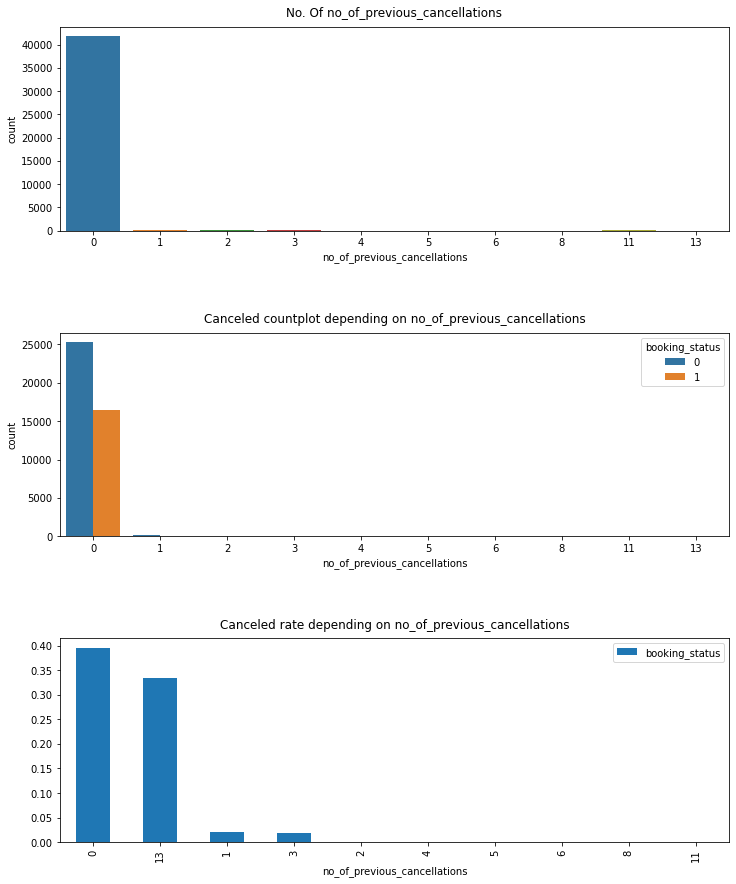

In [ ]:
visualization('no_of_previous_cancellations', 'booking_status')

* 대부분의 사람들은 취소한적이 없다. 
* 예약을 취소한적이 있는 사람들은 대부분 이번에 거의 취소하지 않았다.
* 모델 학습에 중요한 변수로 작용하지 않을 것 같다.

### no_of_previous_bookings_not_canceled

In [ ]:
groupping('no_of_previous_bookings_not_canceled', 'booking_status')

booking_status                 
                                              count    sum      mean
no_of_previous_bookings_not_canceled                                
0                                             40993  16498  0.402459
1                                               262      3  0.011450
2                                               147      0  0.000000
3                                               112      0  0.000000
4                                                87      2  0.022989
5                                               102      0  0.000000
6                                                49      0  0.000000
7                                                44      0  0.000000
8                                                52      0  0.000000
9                                                20      0  0.000000
10                                               34      0  0.000000
11                                               36      0  0.000000
12                                               23      0  0.000000
13                                               10      0  0.000000
14                                               11      0  0.000000
15                                                1      0  0.000000
16                                               14      0  0.000000
17                                                4      0  0.000000
18                                               21      0  0.000000
19                                                2      0  0.000000
20                                               10      0  0.000000
21                                                4      0  0.000000
22                                                1      0  0.000000
23                                                6      0  0.000000
24                                                4      0  0.000000
25                                                2      0  0.000000
26                                                2      0  0.000000
27                                                4      0  0.000000
28                                                1      0  0.000000
30                                                4      0  0.000000
32                                                5      0  0.000000
33                                                4      0  0.000000
35                                                5      0  0.000000
36                                                3      1  0.333333
37                                                2      0  0.000000
41                                                1      0  0.000000
43                                                4      0  0.000000
44                                                2      0  0.000000
46                                                4      0  0.000000
47                                                3      0  0.000000
48                                                3      0  0.000000
58                                                2      0  0.000000

In [ ]:
cross('no_of_previous_bookings_not_canceled', 'booking_status')

booking_status,0,1,All
no_of_previous_bookings_not_canceled,,,
0,24495,16498,40993
1,259,3,262
2,147,0,147
3,112,0,112
4,85,2,87
5,102,0,102
6,49,0,49
7,44,0,44
8,52,0,52


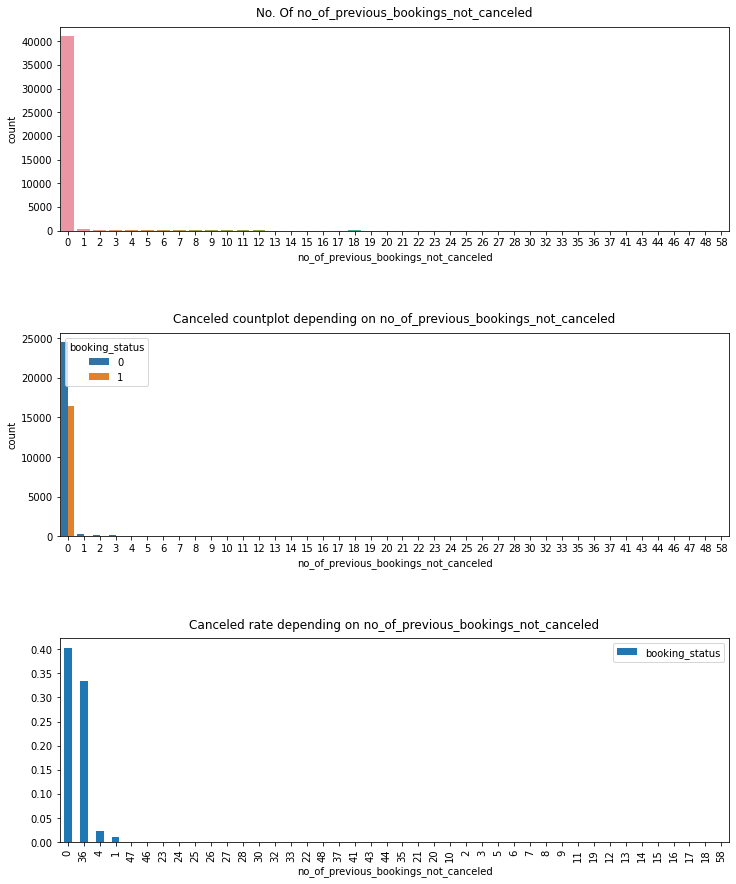

In [ ]:
visualization('no_of_previous_bookings_not_canceled', 'booking_status')

## 2.11 avg_price_per_room

In [ ]:
print('최대 각 방 평균 가격: {:.1f}'.format(df_train['avg_price_per_room'].max()))
print('최소 각 방 평균 가격 : {:.1f}'.format(df_train['avg_price_per_room'].min()))
print('각 방 평균 가격의 평균: {:.1f}'.format(df_train['avg_price_per_room'].mean()))

최대 각 방 평균 가격: 540.0
최소 각 방 평균 가격 : 0.0
각 방 평균 가격의 평균: 104.6


In [ ]:
# 평균 가격이 0인 경우
df_train[df_train['avg_price_per_room'] == 0]

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,ymd
192,192,1,0,0,2,2,0,0,1,2017,12,10,1,0,0,0,0.0,1,0,2017-12-10
234,234,2,0,0,1,0,0,2,0,2018,4,15,1,0,0,0,0.0,0,0,2018-4-15
362,362,1,0,0,1,0,0,2,37,2017,12,2,4,0,0,0,0.0,1,0,2017-12-2
527,527,2,0,0,0,0,0,0,75,2018,11,17,1,0,0,0,0.0,3,0,2018-11-17
617,617,1,0,1,2,2,0,0,80,2018,9,26,1,0,0,0,0.0,0,0,2018-9-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41802,41802,1,0,0,0,1,0,0,36,2018,10,27,1,0,0,0,0.0,0,1,2018-10-27
41812,41812,2,0,0,2,2,0,0,11,2017,10,10,4,0,0,0,0.0,0,0,2017-10-10
41820,41820,1,0,0,0,2,0,0,6,2018,4,10,1,0,0,0,0.0,0,1,2018-4-10
41965,41965,1,0,0,1,0,0,0,4,2018,9,10,4,1,0,1,0.0,1,0,2018-9-10


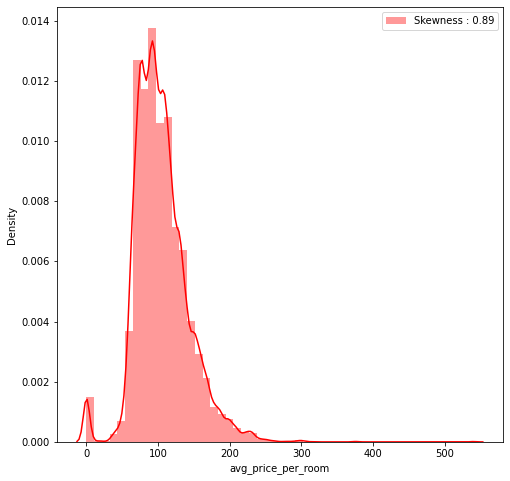

In [ ]:
# avg_price_per_room histogram
fig, ax = plt.subplots(1, 1, figsize = (8,8))

g = sns.distplot(df_train['avg_price_per_room'], color = 'r', label = 'Skewness : {:.2f}'.format(df_train['avg_price_per_room'].skew()), ax = ax)
g = g.legend(loc='best')

* 왜도가 과도하게 크지 않으므로 log를 취할 필요가 없다.

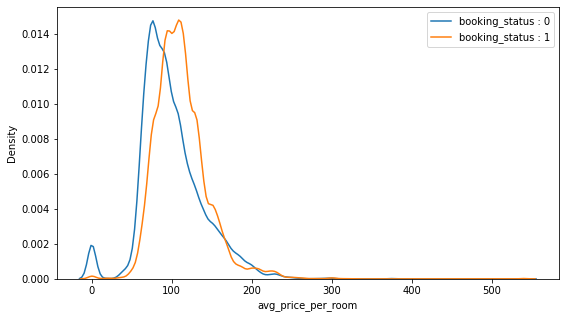

In [ ]:
# 예약 취소에 따른 avg_price_per_room histogram
fig, ax = plt.subplots(1, 1, figsize = (9, 5))

sns.kdeplot(df_train[df_train['booking_status'] == 0]['avg_price_per_room'], ax = ax)

sns.kdeplot(df_train[df_train['booking_status'] == 1]['avg_price_per_room'], ax = ax)

plt.legend(['booking_status : 0', 'booking_status : 1'])
plt.show()

* 예약을 취소하지 않던 취소를 하던 방 평균 가격은 비슷한 양상을 보이고 있다.
* 다만 0원일 경우 취소하지 않은 경우가 많았고 평균 가격에서 조금 더 비쌀경우 취소를 했다.

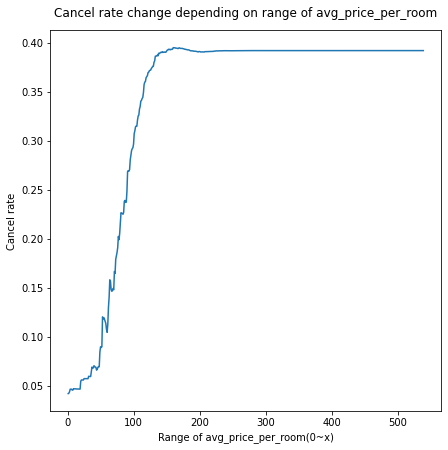

In [ ]:
cummulate_cancel_ratio = []
for i in range(0, 540):
    cummulate_cancel_ratio.append(df_train[df_train['avg_price_per_room'] < i]['booking_status'].sum() / len(df_train[df_train['avg_price_per_room'] < i]['booking_status']))

plt.figure(figsize = (7, 7))
plt.plot(cummulate_cancel_ratio)
plt.title('Cancel rate change depending on range of avg_price_per_room', y = 1.02)
plt.ylabel('Cancel rate')
plt.xlabel('Range of avg_price_per_room(0~x)')
plt.show()

* 200유로까지는 가격이 오를수록 취소확률이 높아지다가 이후에는 취소확률이 일정하게 유지되고 있다.

## 2.12 no_of_special_requests 

In [ ]:
groupping('no_of_special_requests', 'booking_status')

booking_status                 
                                count    sum      mean
no_of_special_requests                                
0                               24554  11710  0.476908
1                               11885   3666  0.308456
2                                4900   1123  0.229184
3                                 660      5  0.007576
4                                 100      0  0.000000
5                                   1      0  0.000000

In [ ]:
cross('no_of_special_requests', 'booking_status')

booking_status,0,1,All
no_of_special_requests,,,
0,12844,11710,24554
1,8219,3666,11885
2,3777,1123,4900
3,655,5,660
4,100,0,100
5,1,0,1
All,25596,16504,42100


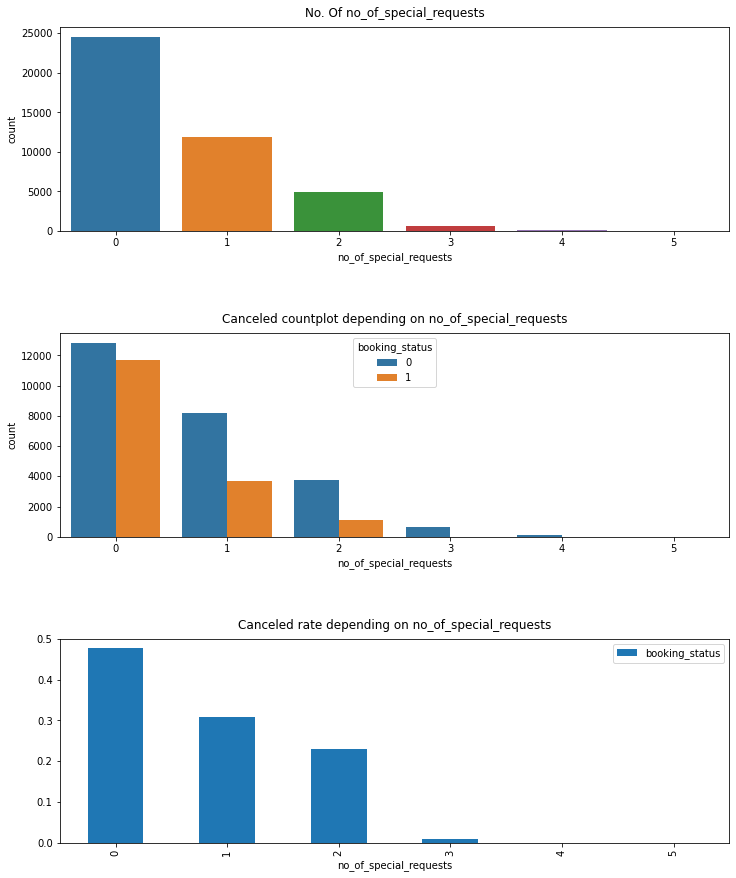

In [ ]:
visualization('no_of_special_requests','booking_status')

* 특별 요청이 대부분 없다.
* 특별 요청이 적을 수록, 예약 취소 확률이 높은걸 확인할 수 있습니다.
    * 0(48%) > 1(31%) > 2(23%) > 3(1%) > 4(0%) > 5(0%)

### 주차 공간이 필요한 사람은 특별 요청이 1이상일까?

In [ ]:
df_train[df_train['required_car_parking_space'] == 1]['no_of_special_requests'].value_counts()

1    475
0    332
2    208
3     48
Name: no_of_special_requests, dtype: int64

* 주차 공간이 필요하다는 것은 특별요청과는 별개이다.

# 3. Feature engineering

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-7/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-7/test.csv')

df_train['familysize'] = df_train['no_of_adults'] + df_train['no_of_children'] + 1
df_test['familysize'] = df_test['no_of_adults'] + df_test['no_of_children'] + 1

df_train['total_nights'] = df_train['no_of_weekend_nights'] + df_train['no_of_week_nights']
df_test['total_nights'] = df_test['no_of_weekend_nights'] + df_test['no_of_week_nights']

## 3.1 Fill Null

* 실제 null 값은 없지만 eda 과정에서 2018년 2월 29일이라는 있을 수 없는 데이터가 존재했다.

In [ ]:
df_train[(df_train['arrival_year'] == 2018) & (df_train['arrival_month'] == 2) & (df_train['arrival_date'] == 29)]

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,familysize,total_nights
2241,2241,1,0,1,3,0,0,0,119,2018,...,29,0,0,0,0,86.00,0,0,2,4
2328,2328,1,0,1,2,0,0,0,3,2018,...,29,2,1,0,1,66.00,0,0,2,3
2912,2912,2,0,1,3,2,0,1,8,2018,...,29,1,0,0,0,189.75,0,1,3,4
2994,2994,3,0,0,5,0,0,1,8,2018,...,29,1,0,0,0,130.00,2,0,4,5
4266,4266,2,1,1,3,0,0,0,7,2018,...,29,1,0,0,0,111.00,2,0,4,4
5913,5913,1,0,0,1,0,0,0,20,2018,...,29,0,0,0,0,117.00,1,0,2,1
6445,6445,2,0,1,2,0,0,0,117,2018,...,29,1,0,0,0,82.45,1,0,3,3
8770,8770,1,0,2,3,0,0,0,115,2018,...,29,0,0,0,0,76.00,0,0,2,5
10830,10830,1,0,0,1,0,0,0,99,2018,...,29,2,0,0,0,81.00,0,0,2,1
13909,13909,1,0,0,1,0,0,0,47,2018,...,29,0,0,0,0,72.00,0,0,2,1


* 29일을 무슨 값으로 대체해줘야할지 아직 정하지 못함.

## 3.2 heatmap

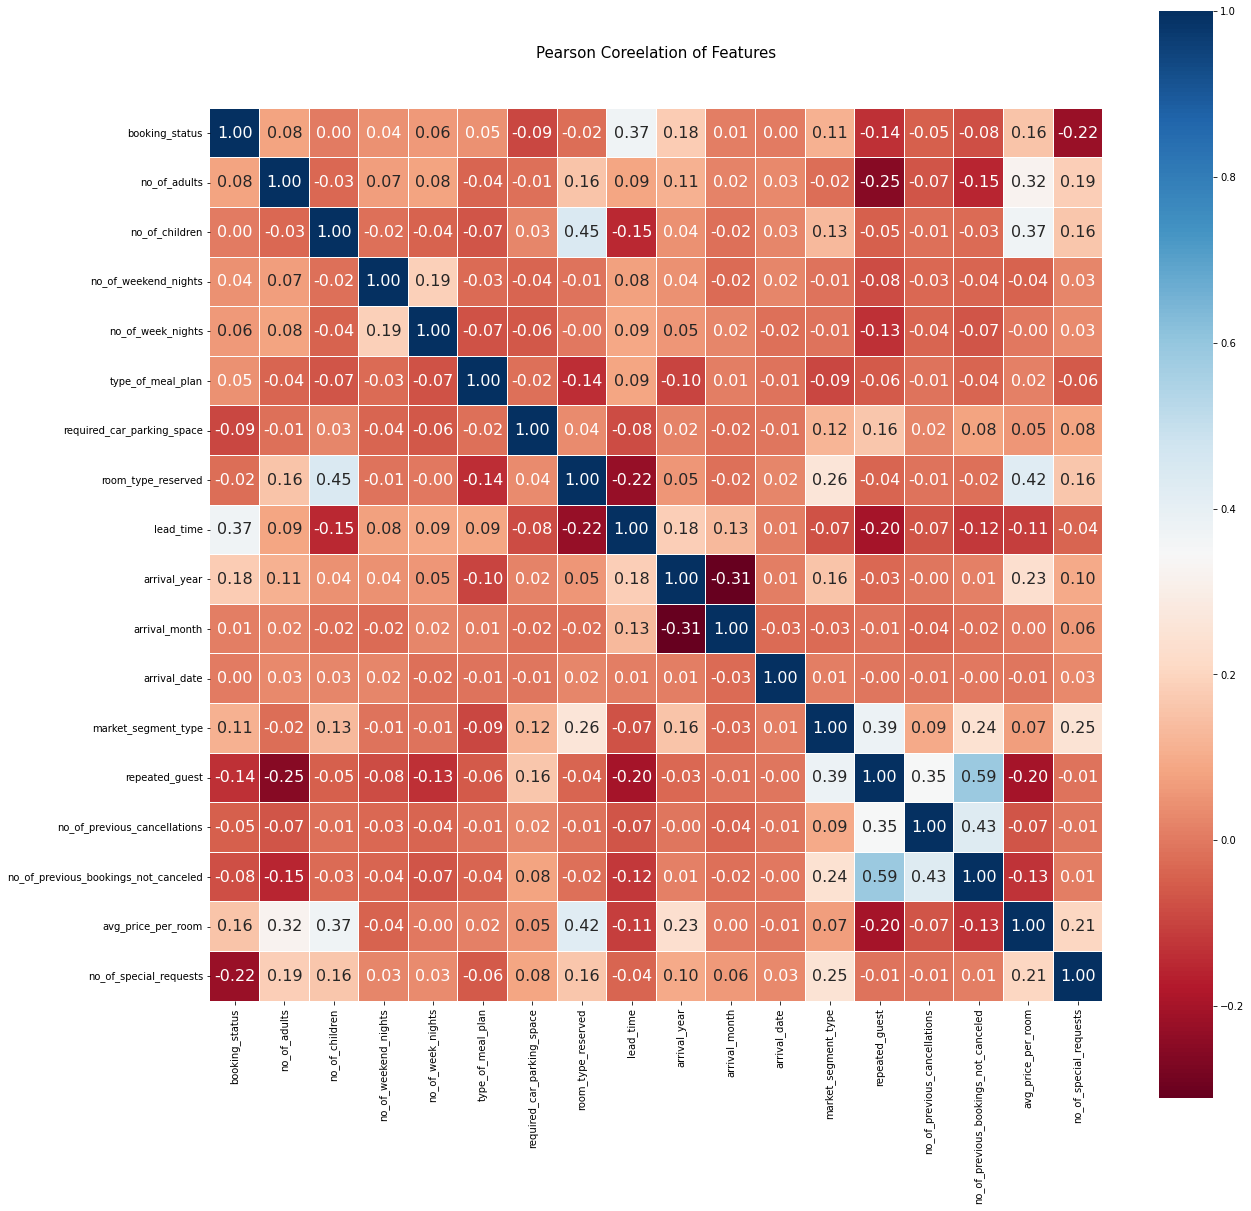

In [ ]:
heatmap_data = df_train[['booking_status','no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests']]

colormap = plt.cm.RdBu
plt.figure(figsize = (20, 20))
plt.title('Pearson Coreelation of Features', y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = 'white', annot = True, annot_kws = {"size" : 16}, fmt = ".2f")

del heatmap_data

* booking_status와 상관관계가 어느정도 있는 것은 lead_time 과 no_of_special_requests이다.
* no_of_previous_booking_not_canceld 와 repeated_guests가 상관관계가 있음을 볼 수 있다. 
* no_of_children과 room_type_reserved도 상관관계가 있다.
* 서로 강한 상관관계를 가지고 있는 feature는 없다.

## 3.3 One-hot encoding

In [ ]:
df_train = pd.get_dummies(df_train, columns = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'no_of_special_requests'])
df_test = pd.get_dummies(df_test, columns = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'no_of_special_requests'])

In [ ]:
df_train

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,...,market_segment_type_1,market_segment_type_2,market_segment_type_3,market_segment_type_4,no_of_special_requests_0,no_of_special_requests_1,no_of_special_requests_2,no_of_special_requests_3,no_of_special_requests_4,no_of_special_requests_5
0,0,2,0,0,2,0,9,2018,1,14,...,1,0,0,0,1,0,0,0,0,0
1,1,2,0,1,2,0,117,2018,7,29,...,0,0,0,0,1,0,0,0,0,0
2,2,2,0,0,1,0,315,2018,12,2,...,0,0,0,0,1,0,0,0,0,0
3,3,1,0,0,2,0,32,2018,12,1,...,1,0,0,0,1,0,0,0,0,0
4,4,2,0,1,0,0,258,2018,10,16,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,42095,3,0,0,4,0,160,2018,12,30,...,1,0,0,0,0,0,1,0,0,0
42096,42096,2,0,0,3,0,34,2017,9,23,...,0,0,0,0,1,0,0,0,0,0
42097,42097,2,0,0,2,0,292,2018,7,21,...,0,0,0,0,1,0,0,0,0,0
42098,42098,1,0,0,3,0,5,2018,11,9,...,0,0,0,0,1,0,0,0,0,0


## 3.4 Drop columns

# 4. Building machine learning model and prediction using the trained model

## 4.1 Preparation - Split dataset into train, valid, test set

In [ ]:
X_train = df_train.drop(['id', 'booking_status'], axis = 1)
target_label = df_train['booking_status']
X_test = df_test.drop('id', axis = 1)

In [ ]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size = 0.3, random_state = 42)

## 4.2 Model generation and prediction

In [ ]:
model = RandomForestClassifier(n_estimators = 300, max_depth = 10, criterion = 'entropy',random_state = 42)
model.fit(X_tr, y_tr)
prediction = model.predict_proba(X_vld)[:,1]

In [ ]:
print('두번째 시도 정확도 : {:.2f}%'. format(100 * roc_auc_score(y_vld, prediction)))

두번째 시도 정확도 : 88.30%


## 4.3 Feature importance

In [ ]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index = X_test.columns)

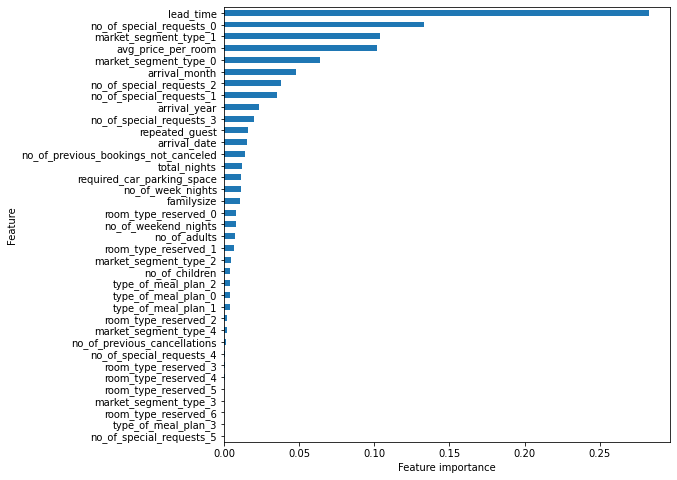

In [ ]:
plt.figure(figsize = (8,8))
Series_feat_imp.sort_values(ascending = True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

## 4.4 Prediction on Test set

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/data/3-7/sample_submission.csv')
sub.head()

,id,booking_status
0,42100,0.24
1,42101,0.13
2,42102,0.57
3,42103,0.18
4,42104,0.37


In [ ]:
prediction = model.predict_proba(X_test)[:,1]
sub['booking_status'] = prediction
sub['booking_status']

0        0.145763
1        0.090200
2        0.314013
3        0.154248
4        0.606530
           ...   
28063    0.902440
28064    0.058223
28065    0.173191
28066    0.638054
28067    0.847705
Name: booking_status, Length: 28068, dtype: float64

In [ ]:
sub.to_csv('/content/drive/MyDrive/data/3-7/sample_submission.csv', index = False)

# 세번째 시도

* feature engineering을 한 것보다 안 한것의 정확도가 높게 나왔기 때문에 우선 engineering 없는 데이터를 가지고 정확도를 올려보자!!

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-7/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-7/test.csv')

## Cross Validation

In [ ]:
X = df_train[df_train.columns[1:18]]
Y = df_train['booking_status']

kfold = KFold(n_splits=10, random_state=42, shuffle = True)

xyz=[]
accuracy=[]
std=[]

classifiers = ['Random Forest']
models = [RandomForestClassifier(n_estimators = 300, max_depth = 10, criterion = 'entropy',random_state = 42)]

for i in models:
    model = i
    cv_result = cross_val_score(model, X,Y, cv = kfold, scoring = 'accuracy')
    cv_result = cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2 = pd.DataFrame({'CV Mean':xyz, 'Std':std}, index = classifiers)
new_models_dataframe2

,CV Mean,Std
Random Forest,0.813397,0.004922


<AxesSubplot:>

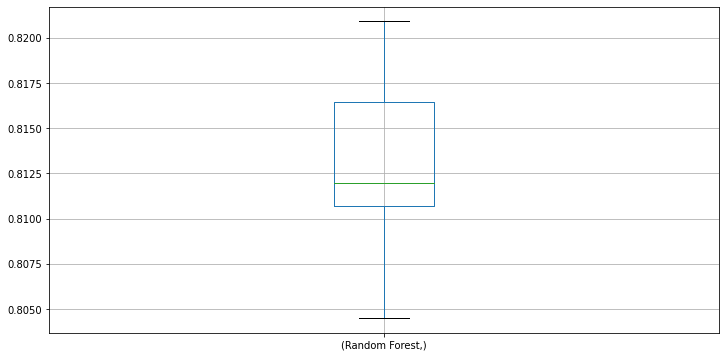

In [ ]:
plt.subplots(figsize = (12,6))
box = pd.DataFrame(accuracy, index = [classifiers])
box.T.boxplot()

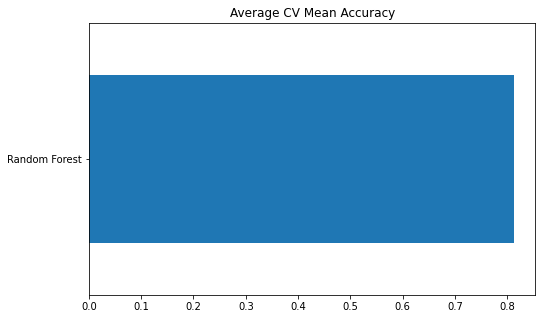

In [ ]:
new_models_dataframe2['CV Mean'].plot.barh(width = 0.8)
plt.title('Average CV Mean Accuracy')
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()

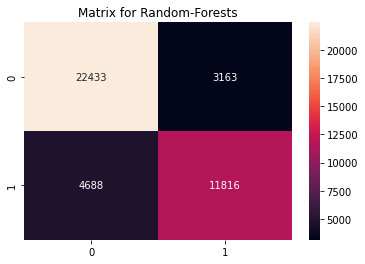

In [ ]:
# confusion matrix
y_pred = cross_val_predict(RandomForestClassifier(n_estimators = 300, max_depth = 10, criterion = 'entropy',random_state = 42), X, Y, cv = 10)
sns.heatmap(confusion_matrix(Y, y_pred), annot = True, fmt='2.0f')
plt.title('Matrix for Random-Forests')
plt.show()

81.35%

In [ ]:
n_estimators = range(100, 1000, 100)
hyper = {'n_estimators' : n_estimators}

gd = GridSearchCV(estimator = RandomForestClassifier(max_depth = 10, criterion='entropy', random_state = 42), param_grid=hyper,verbose=True)
gd.fit(X,Y)

print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.8133491686460808
RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=900,
                       random_state=42)


Ensembling : 모델의 정확도나 성능을 높이는 방법

# 세번째 시도

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-7/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-7/test.csv')

df_train['familysize'] = df_train['no_of_adults'] + df_train['no_of_children'] + 1
df_test['familysize'] = df_test['no_of_adults'] + df_test['no_of_children'] + 1

df_train['total_nights'] = df_train['no_of_weekend_nights'] + df_train['no_of_week_nights']
df_test['total_nights'] = df_test['no_of_weekend_nights'] + df_test['no_of_week_nights']

In [ ]:
# train 데이터 X, y 분리
X_train = df_train.drop(['id', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'booking_status'], axis = 1)
y_train = df_train['booking_status']

# test 데이터 id 제외
df_test = df_test.copy()
df_test_new = df_test.drop(['id','no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights'], axis = 1)

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

model = RandomForestClassifier(n_estimators = 900, max_depth = 10, criterion = 'entropy',random_state = 42)
model.fit(X_tr, y_tr)
prediction = model.predict_proba(X_vld)[:, 1]

print('세번째 시도 정확도 : {:.2f}%'. format(100 * roc_auc_score(y_vld, prediction)))

세번째 시도 정확도 : 88.47%


In [ ]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index = df_test_new.columns)

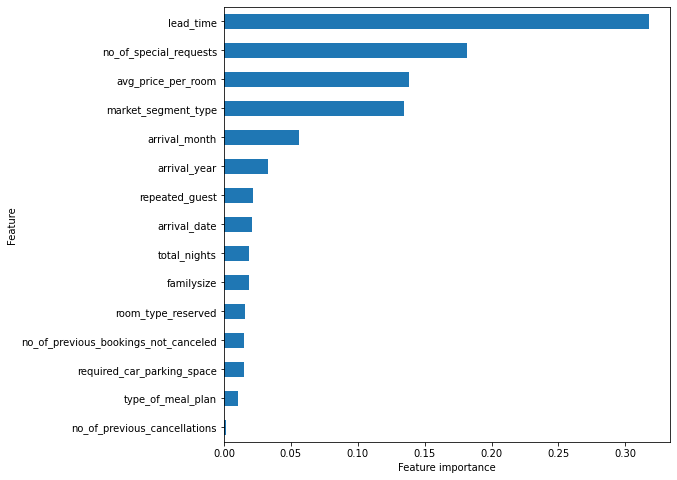

In [ ]:
plt.figure(figsize = (8,8))
Series_feat_imp.sort_values(ascending = True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/data/3-7/sample_submission.csv')
prediction = model.predict_proba(df_test_new)[:,1]
sub['booking_status'] = prediction
sub.to_csv('/content/drive/MyDrive/data/3-7/sample_submission.csv', index = False)

# 네번째 시도

## catboost 이용

In [35]:
X = df_train.drop(['id', 'booking_status'] , axis = 1)
y = df_train['booking_status']

In [36]:
X['avg_price_per_room'] = X['avg_price_per_room'].astype(np.int) # catboost는 float 변수는 사용 불가능?
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [38]:
clf = CatBoostClassifier(
    iterations = 5,
    learning_rate = 0.1,
    loss_function = 'CrossEntropy'
)

clf.fit(X_train, y_train,
        cat_features = cat_features,
        eval_set = (X_val, y_val),
        verbose = False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1, 'loss_function': 'CrossEntropy'}


In [39]:
clf = CatBoostClassifier(
    iterations = 10,
    verbose = 5
)

clf.fit(
    X_train, y_train,
    cat_features = cat_features,
    eval_set = (X_val, y_val)
)

Learning rate set to 0.5
0:	learn: 0.5863997	test: 0.5851339	best: 0.5851339 (0)	total: 38.5ms	remaining: 346ms
5:	learn: 0.4477704	test: 0.4406975	best: 0.4406975 (5)	total: 198ms	remaining: 132ms
9:	learn: 0.4341207	test: 0.4279180	best: 0.4279180 (9)	total: 320ms	remaining: 0us

bestTest = 0.4279180092
bestIteration = 9



In [40]:
df_test = df_test.drop('id', axis = 1)
df_test['avg_price_per_room'] = df_test['avg_price_per_room'].astype(np.int)

In [44]:
prediction = clf.predict_proba(X_val)[:, 1]

print('네번째 시도 정확도 : {:.2f}%'. format(100 * roc_auc_score(y_val, prediction)))

네번째 시도 정확도 : 87.74%


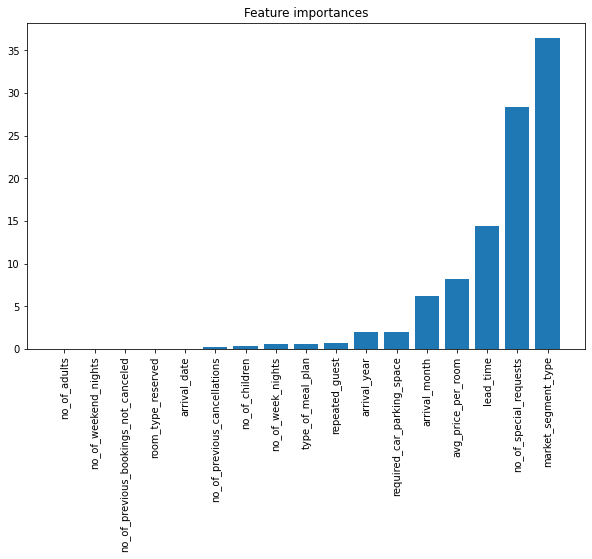

In [41]:
# 모델링에 사용된 변수들의 중요도 시각화
importances = clf.feature_importances_

indices_sorted = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X_train.columns[indices_sorted], rotation = 90)
plt.show()

## XGB 활용

In [97]:
df_train = pd.read_csv('/content/drive/MyDrive/data/3-7/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/3-7/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/data/3-7/sample_submission.csv')

# df_train['familysize'] = df_train['no_of_adults'] + df_train['no_of_children'] + 1
# df_test['familysize'] = df_test['no_of_adults'] + df_test['no_of_children'] + 1

# df_train['total_nights'] = df_train['no_of_weekend_nights'] + df_train['no_of_week_nights']
# df_test['total_nights'] = df_test['no_of_weekend_nights'] + df_test['no_of_week_nights']

# df_train['lead_time_x_total_nights'] = df_train['lead_time'] * df_train['total_nights']
# df_test['lead_time_x_total_nights'] = df_test['lead_time'] * df_test['total_nights']

In [98]:
# train 데이터 X, y 분리
X_train = df_train.drop(['id','booking_status'], axis = 1)
y_train = df_train['booking_status']

# test 데이터 id 제외
df_test = df_test.drop(['id'], axis = 1)

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

# model = RandomForestClassifier(n_estimators = 300, max_depth = 10, criterion = 'entropy',random_state = 42)
model = xgb.XGBClassifier(n_estimators = 300, max_depth = 10, criterion = 'entropy', random_state = 42)
model.fit(X_tr, y_tr)
prediction = model.predict_proba(X_vld)[:, 1]

print('네번째 시도 정확도 : {:.2f}%'. format(100 * roc_auc_score(y_vld, prediction)))

네번째 시도 정확도 : 89.27%


In [99]:
xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(150, 100)

Output hidden; open in https://colab.research.google.com to view.

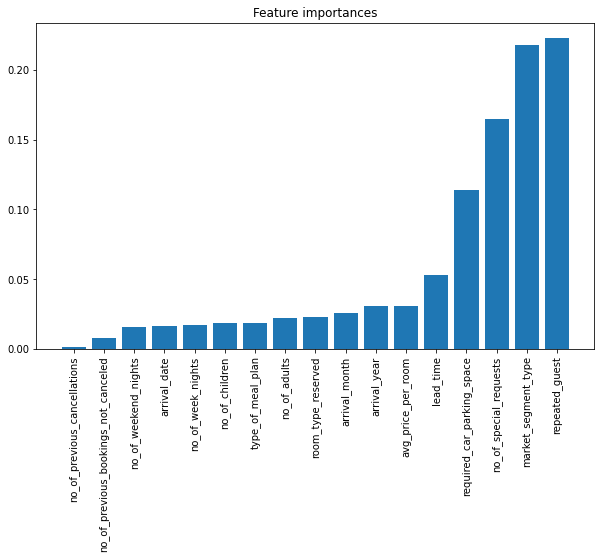

In [100]:
# 모델링에 사용된 변수들의 중요도 시각화
importances = model.feature_importances_

indices_sorted = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices_sorted])
plt.xticks(range(len(importances)), X_train.columns[indices_sorted], rotation = 90)
plt.show()

In [101]:
predictions = model.predict_proba(df_test)[:,1]

sub['booking_status'] = predictions
sub.to_csv('/content/drive/MyDrive/data/3-7/sample_submission.csv', index = False)